In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [85]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

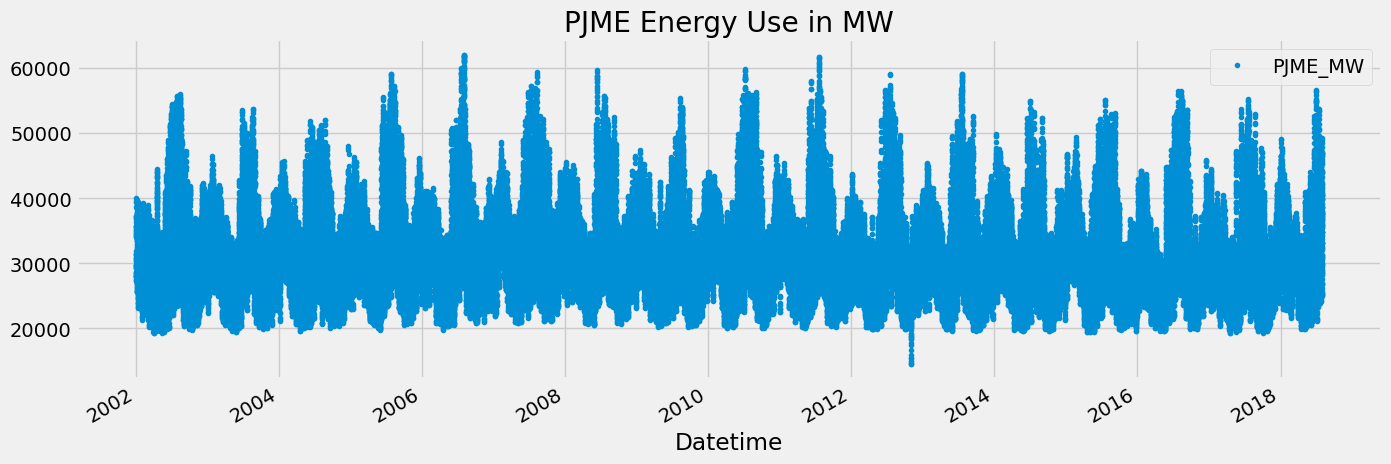

In [86]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

# Train / Test Split

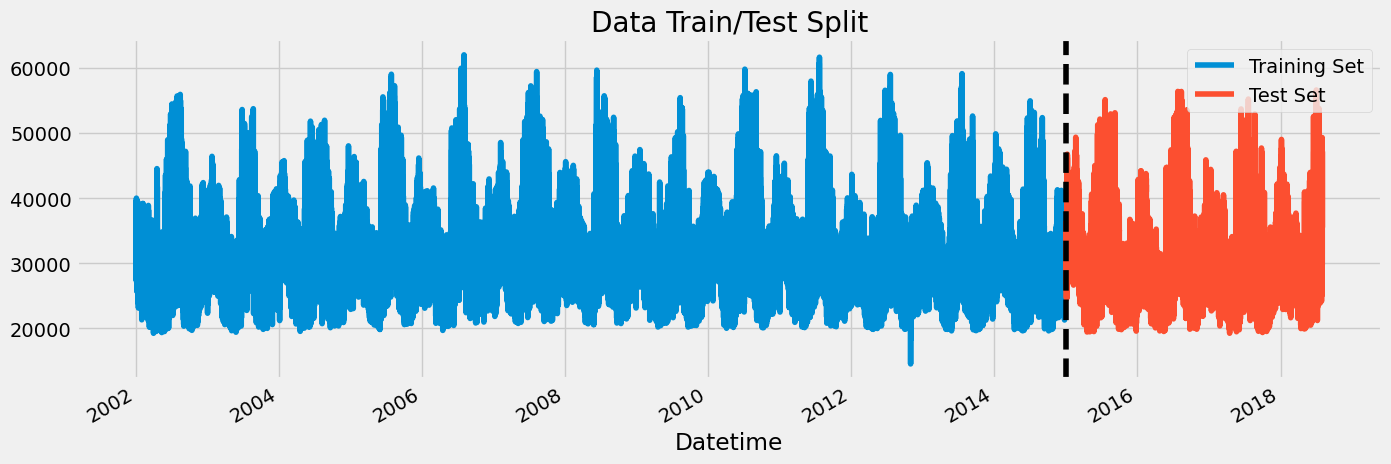

In [87]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

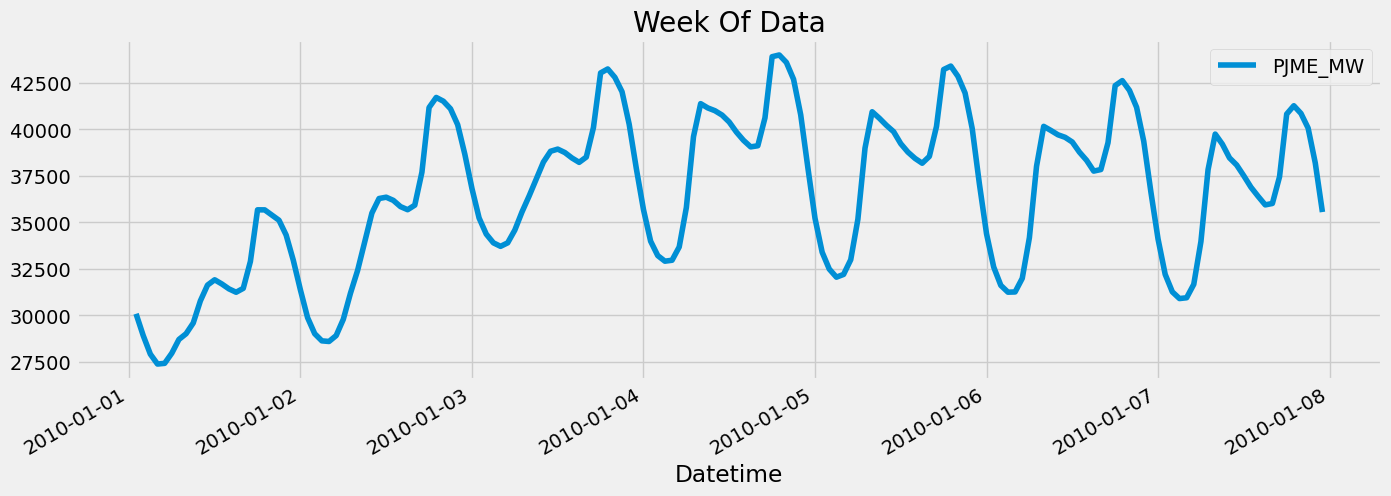

In [88]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Feature Creation

In [89]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

df = create_features(df)

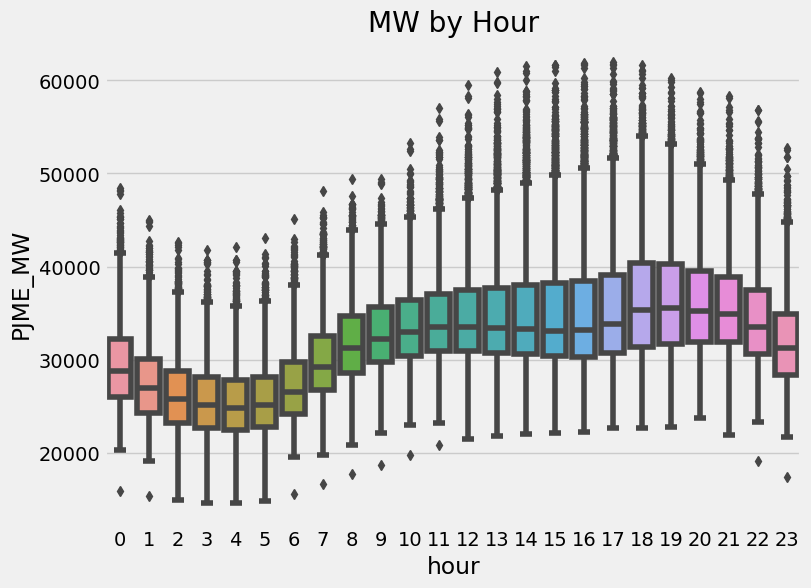

In [90]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

In [91]:
# we observe that the energy consumption is higher as the day progresses.

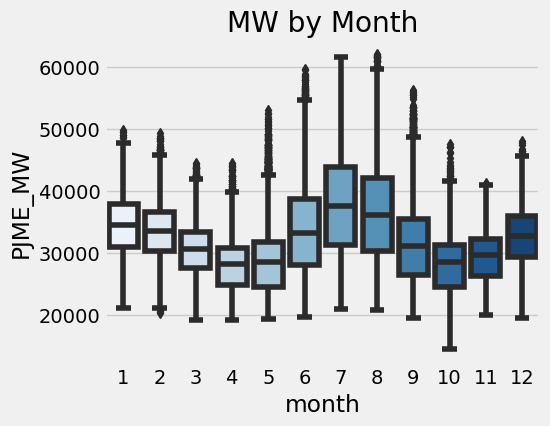

In [92]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

In [93]:
# As expected the energy consumption is higher in the summer months.

# Model

In [94]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [95]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.23208	validation_1-rmse:31657.33255


/Users/praneethkruthiventi/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:51:31] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12602.63804	validation_1-rmse:11766.99278
[200]	validation_0-rmse:5906.68748	validation_1-rmse:5450.71312
[300]	validation_0-rmse:4060.33490	validation_1-rmse:4142.62021
[400]	validation_0-rmse:3601.22122	validation_1-rmse:3984.58335
[500]	validation_0-rmse:3459.17197	validation_1-rmse:3944.15492
[600]	validation_0-rmse:3390.56792	validation_1-rmse:3911.21085
[700]	validation_0-rmse:3345.84543	validation_1-rmse:3895.07618
[800]	validation_0-rmse:3316.94598	validation_1-rmse:3882.86053
[900]	validation_0-rmse:3295.16587	validation_1-rmse:3875.29575
[999]	validation_0-rmse:3276.49225	validation_1-rmse:3870.52965


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

# Feature Importance

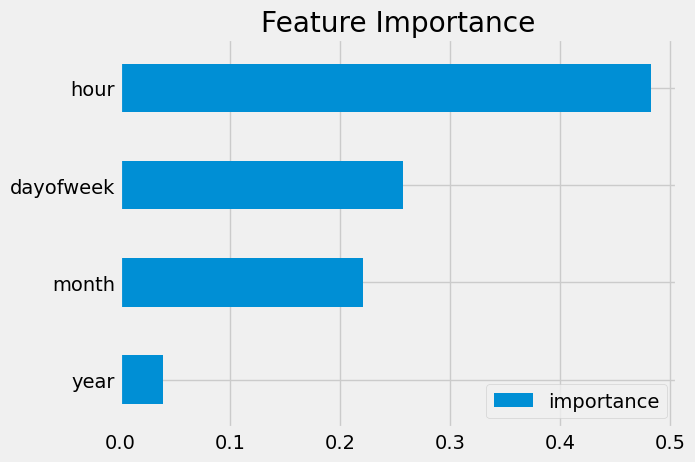

In [96]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [97]:
# Here all the features are a different label of time. But it is clear from the above picture that 

# Forecast on Test Data

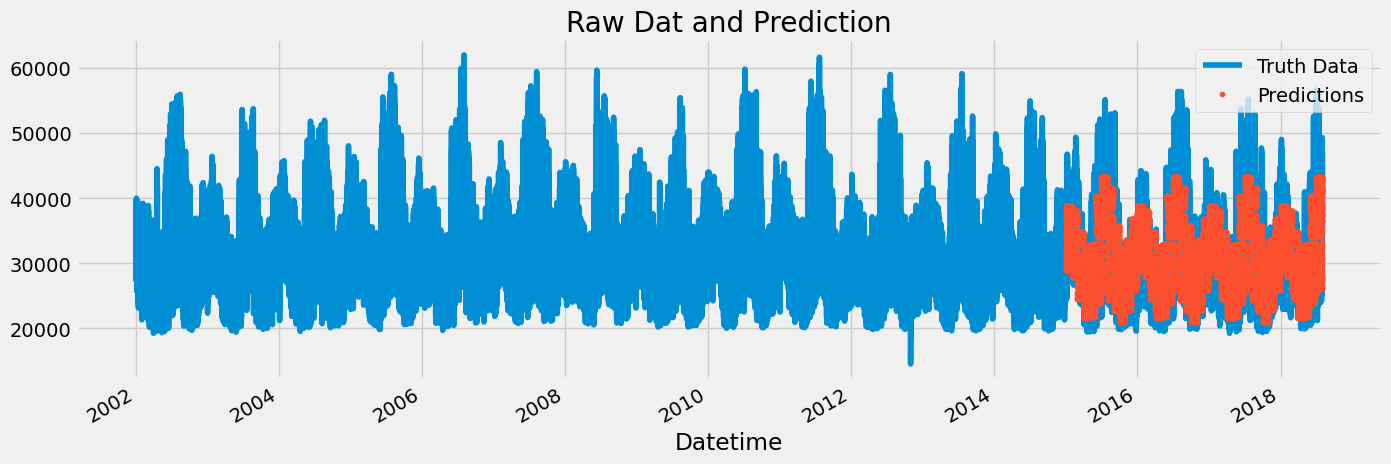

In [98]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

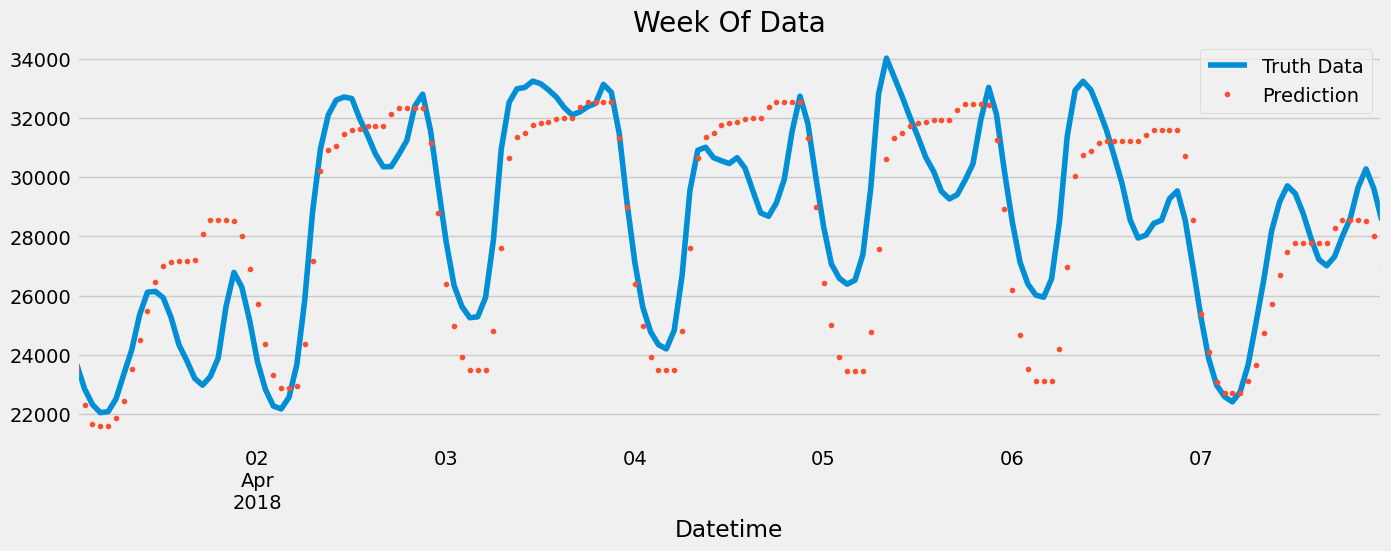

In [99]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# RMSE

In [100]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3870.53


# Calculated Error

In [101]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    13008.167480
2016-08-14    12937.072673
2016-09-09    12932.676025
2016-09-10    12776.896647
2015-09-09    10820.063477
2016-08-12    10691.420654
2018-01-06    10407.932454
2015-02-20    10294.679932
2016-09-08    10185.790853
2016-08-11     9664.950765
Name: error, dtype: float64